In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU ,Bidirectional
from keras.layers import Reshape
# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [5]:

# Step 1: Data cleaning
data = yf.download(tickers='ETH-usd', start='2017-11-09', end='2022-12-31', interval='1d')
#data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2022-12-26,1218.920166,1226.974365,1214.335938,1226.974365,1226.974365,3282098400
2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,1212.791626,4091530737
2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,1189.986084,4991669631


In [6]:
data = data.drop(['Close'], axis=1)
data

,Open,High,Low,Adj Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984
...,...,...,...,...,...
2022-12-26,1218.920166,1226.974365,1214.335938,1226.974365,3282098400
2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,4091530737
2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,4991669631


In [7]:
data= data.to_csv('ETH_case2.csv')

In [5]:
from datetime import datetime

def date_parser(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    return date_obj.strftime('%m-%d-%Y')


In [2]:
data_csv = pd.read_csv('ETH_case2.csv')
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv.dropna(inplace=True)
data_csv.info()
data_csv.tail(10)

<class 'pandas.core.frame.DataFrame'>
Index: 1878 entries, 2017-11-09 to 2022-12-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1878 non-null   float64
 1   High       1878 non-null   float64
 2   Low        1878 non-null   float64
 3   Adj Close  1878 non-null   float64
 4   Volume     1878 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 88.0+ KB


,Open,High,Low,Adj Close,Volume
Date,,,,,
2022-12-21,1217.586426,1218.192261,1206.440063,1213.599976,4217182733
2022-12-22,1213.672607,1221.986816,1187.127808,1218.182129,5297471739
2022-12-23,1218.079346,1226.998779,1215.994873,1220.159424,4835831923
2022-12-24,1220.117920,1224.911621,1216.338745,1221.148560,2626153345
2022-12-25,1221.171509,1223.517822,1203.719604,1218.962036,3942720070
2022-12-26,1218.920166,1226.974365,1214.335938,1226.974365,3282098400
2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,4091530737
2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,4991669631
2022-12-29,1190.010132,1204.141602,1188.360229,1201.595337,4132233940


In [3]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(1878, 5)

In [5]:
test_data =test_df.copy()

In [13]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()


In [6]:
print(train_df.info())
print(test_df.info())
print('test_data', test_data.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 1502 entries, 2017-11-09 to 2021-12-19
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1502 non-null   float64
 1   High       1502 non-null   float64
 2   Low        1502 non-null   float64
 3   Adj Close  1502 non-null   float64
 4   Volume     1502 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 376 entries, 2021-12-20 to 2022-12-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       376 non-null    float64
 1   High       376 non-null    float64
 2   Low        376 non-null    float64
 3   Adj Close  376 non-null    float64
 4   Volume     376 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 17.6+ KB
None
test_data (376, 5)


In [7]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (1502, 4)
y_train (1502,)
X_test (376, 4)
y_test (376,)


In [8]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test  = y_test.reshape(-1,1)
y_test  = scaler.fit_transform(y_test)
#------------------------------------------
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape) 

x_train (1502, 4)
y_train (1502, 1)
X_test (376, 4)
y_test (376, 1)


In [9]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])


X_train (1502, 1, 4)
y_train (1502, 1)
X_test (376, 1, 4)
Y_test (376, 1)
X_train.shape[1] 1
X_train.shape[2] 4


In [10]:
# Step 6: Building the hybrid model (cont.)

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True , activation= 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,activation= 'tanh'))
model.add(Dropout(0.2))
model.add(Reshape((1, 100))) # Add a Reshape layer to convert output shape to (batch_size, timesteps, features)
model.add(Bidirectional(LSTM(75, return_sequences=True,activation= 'tanh')))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(75,activation= 'tanh')))
model.add(Dropout(0.25))
model.add(Reshape((1, 150))) # Add a Reshape layer to convert output shape to (batch_size, timesteps, features)
model.add(GRU(50, activation=  "tanh"))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            42000     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 reshape (Reshape)           (None, 1, 100)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 150)           105600    
 l)                                                              
                                                        

In [11]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)


Epoch 1/1000
47/47 [==============================] - 31s 28ms/step - loss: 0.0451 - accuracy: 6.6578e-04 - mean_absolute_error: 0.1475
Epoch 2/1000
47/47 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.0013 - mean_absolute_error: 0.0402
Epoch 3/1000
47/47 [==============================] - 1s 22ms/step - loss: 0.0022 - accuracy: 0.0013 - mean_absolute_error: 0.0252
Epoch 4/1000
47/47 [==============================] - 1s 22ms/step - loss: 0.0020 - accuracy: 0.0013 - mean_absolute_error: 0.0231
Epoch 5/1000
47/47 [==============================] - 1s 22ms/step - loss: 0.0021 - accuracy: 0.0013 - mean_absolute_error: 0.0235
Epoch 6/1000
47/47 [==============================] - 1s 23ms/step - loss: 0.0017 - accuracy: 0.0013 - mean_absolute_error: 0.0214
Epoch 7/1000
47/47 [==============================] - 1s 23ms/step - loss: 0.0019 - accuracy: 0.0013 - mean_absolute_error: 0.0237
Epoch 8/1000
47/47 [==============================] - 1s 22ms/step - loss: 0.0

In [12]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


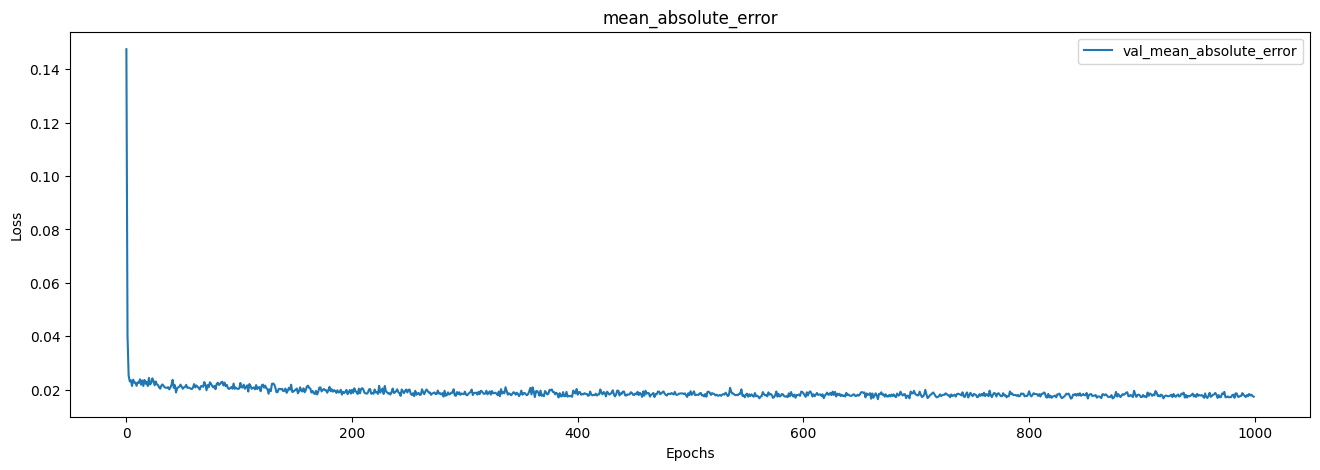

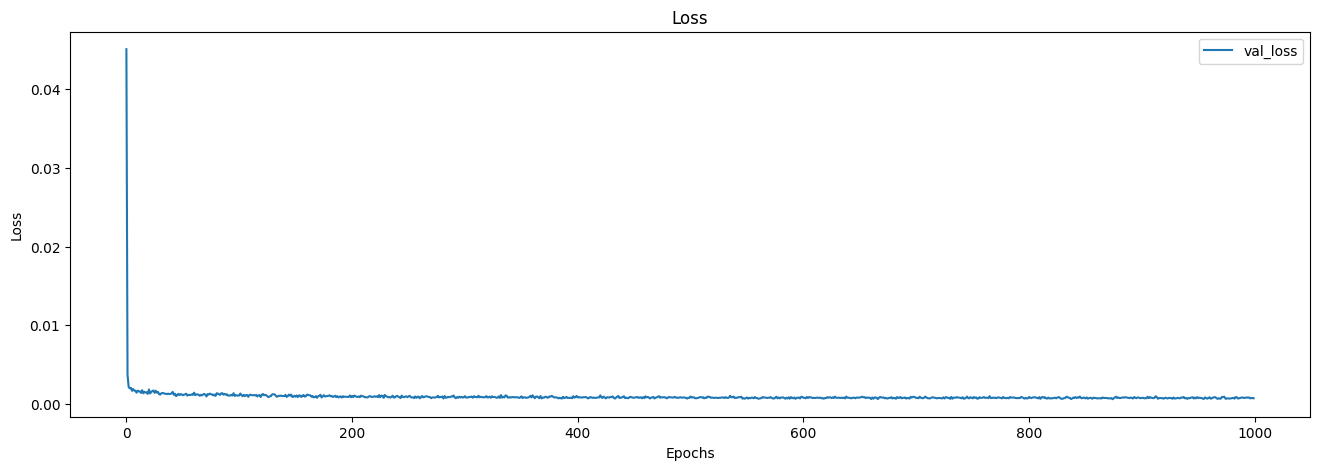

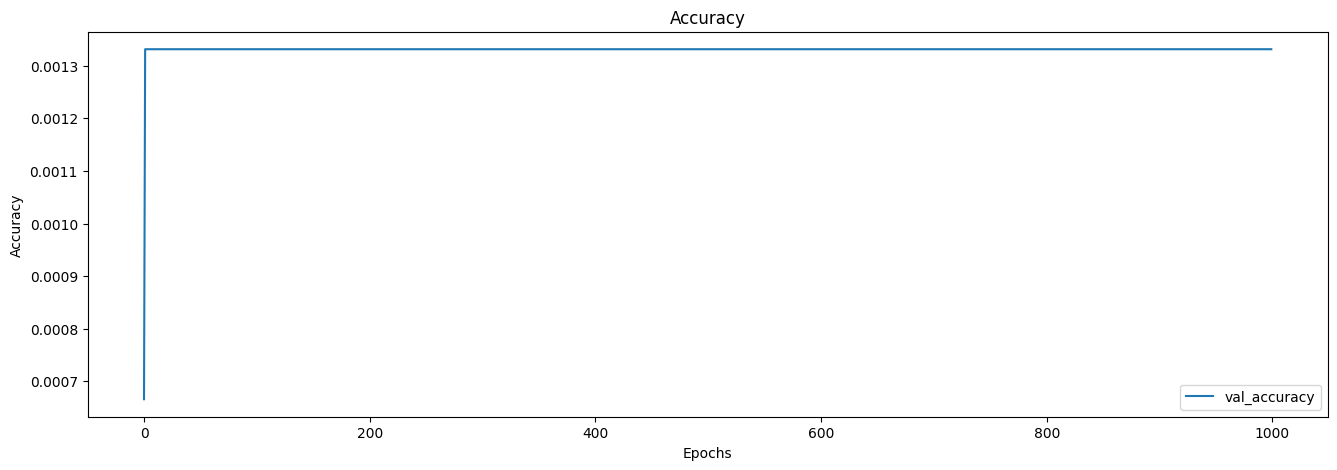

In [13]:
visualize_training_results(history)


In [14]:
# Evaluate the model on the test set
mse, accuracy, mae = model.evaluate(X_test, y_test)


12/12 [==============================] - 16s 7ms/step - loss: 2.5453e-04 - accuracy: 0.0053 - mean_absolute_error: 0.0119


## Evaluat For Train

In [15]:
y_train_pred = model.predict(X_train)

print('y_train_pred', y_train_pred.shape)
print('y_test', y_train.shape)


# evaluat
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))

print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

47/47 [==============================] - 6s 9ms/step
y_train_pred (1502, 1)
y_test (1502, 1)
RMSE: 0.0104
MSE: 0.0001
MAE:0.0060


In [16]:
from sklearn.metrics import confusion_matrix
bins = np.linspace(0, 1, num=11)

# discretize y_test into categories
y_train_cat = np.digitize(y_train, bins) - 1  # subtract 1 to make categories start from 0

# convert probabilities to binary labels using a threshold
y_pred_prob = y_train_pred.copy()
y_pred_binary = np.where(y_pred_prob >= 0.5, 1, 0)



# calculate confusion matrix
cm = confusion_matrix(y_train_cat, y_pred_binary)

print(cm)


[[966   0   0   0   0   0   0   0   0   0   0]
 [162   0   0   0   0   0   0   0   0   0   0]
 [ 58   0   0   0   0   0   0   0   0   0   0]
 [ 65   0   0   0   0   0   0   0   0   0   0]
 [ 63   1   0   0   0   0   0   0   0   0   0]
 [  8  29   0   0   0   0   0   0   0   0   0]
 [  0  44   0   0   0   0   0   0   0   0   0]
 [  0  37   0   0   0   0   0   0   0   0   0]
 [  0  46   0   0   0   0   0   0   0   0   0]
 [  0  22   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0]]


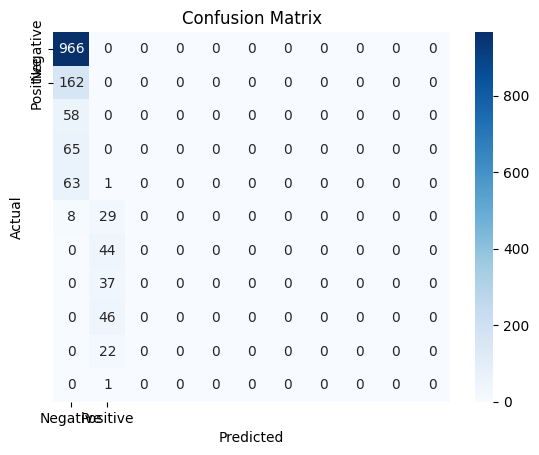

In [17]:
import seaborn as sns
# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Set tick positions and labels
tick_positions = [0.5, 1.5]
tick_labels = ['Negative', 'Positive']
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# Show the plot
plt.show()


In [18]:
class_names = ["negative", "positive"]


# convert y_test and y_pred to binary
y_train_binary = y_train.copy()
y_train_binary[y_train_binary != class_names.index("positive")] = 0
y_train_binary[y_train_binary == class_names.index("positive")] = 1

y_pred_prob = y_train_pred.copy()
y_pred_binary = np.where(y_pred_prob >= 0.5, 1, 0)

# calculate confusion matrix
cm = confusion_matrix(y_train_binary, y_pred_binary)

# calculate TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()

print("True Negative (TN):", tn)
print("False Positive (FP):", fp)
print("False Negative (FN):", fn)
print("True Positive (TP):", tp)
print("Total samples:", len(y_train_binary))


True Negative (TN): 1322
False Positive (FP): 179
False Negative (FN): 0
True Positive (TP): 1
Total samples: 1502


In [19]:

Accuracy = (tp + tn) / (tp + tn + fp + fn)
recall  = tp / (tp + fn)
Specificity = tn / (tn + fp)
Precision = tp / (tp + fp)
f1 = 2 * (Precision * recall) / (Precision + recall)

print("Accuracy: ", round((Accuracy* 100),2))

print("Recall :",round ((recall * 100 ),2 ))

print("Specificity :",round ((Specificity * 100 ),2 ))

print ("Precision:", round((Precision * 100),2))

print('F-Score:', round((f1 * 100),2))




Accuracy:  88.08
Recall : 100.0
Specificity : 88.07
Precision: 0.56
F-Score: 1.1


# Evaluat For Test

In [20]:
y_test_pred = model.predict(X_test)

print('y_test_pred', y_test_pred.shape)
print('y_test', y_test.shape)


# evaluat
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)

rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

12/12 [==============================] - 0s 8ms/step
y_test_pred (376, 1)
y_test (376, 1)
RMSE: 0.0160
MSE: 0.0003
MAE:0.0119


In [21]:
from sklearn.metrics import confusion_matrix
bins = np.linspace(0, 1, num=11)

# discretize y_test into categories
y_test_cat = np.digitize(y_test, bins) - 1  # subtract 1 to make categories start from 0

# convert probabilities to binary labels using a threshold
y_pred_prob1 = y_test_pred.copy()
y_pred_binary1 = np.where(y_pred_prob1>= 0.5, 1, 0)



# calculate confusion matrix
cm_test = confusion_matrix(y_test_cat, y_pred_binary1)

print(cm_test)


[[95  0  0  0  0  0  0  0  0  0  0]
 [70  0  0  0  0  0  0  0  0  0  0]
 [50  0  0  0  0  0  0  0  0  0  0]
 [19  0  0  0  0  0  0  0  0  0  0]
 [11  1  0  0  0  0  0  0  0  0  0]
 [ 2 38  0  0  0  0  0  0  0  0  0]
 [ 0 48  0  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]]


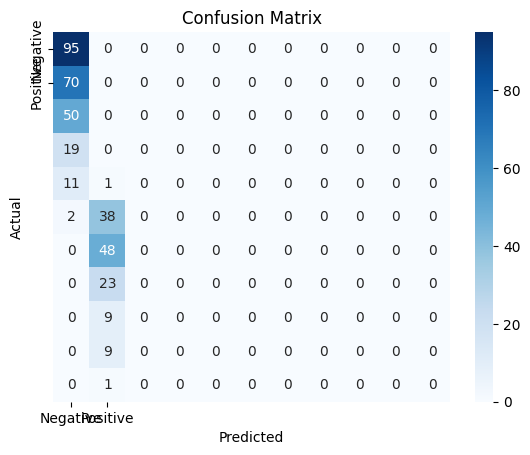

In [22]:

# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap using seaborn
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g')

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Set tick positions and labels
tick_positions = [0.5, 1.5]
tick_labels = ['Negative', 'Positive']
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# Show the plot
plt.show()


In [23]:
cclass_names = ["negative", "positive"]


# convert y_test and y_pred to binary
y_test_binary = y_test.copy()
y_test_binary[y_test_binary != class_names.index("positive")] = 0
y_test_binary[y_test_binary == class_names.index("positive")] = 1

y_pred_prob1 = y_test_pred.copy()
y_pred_binary1 = np.where(y_pred_prob1 >= 0.5, 1, 0)

# calculate confusion matrix
cm_test = confusion_matrix(y_test_binary, y_pred_binary1)

# calculate TN, FP, FN, TP
tn_t, fp_t, fn_t, tp_t = cm_test.ravel()

print("True Negative (TN):", tn_t)
print("False Positive (FP):", fp_t)
print("False Negative (FN):", fn_t)
print("True Positive (TP):", tp_t)
print("Total samples:", len(y_test_binary))


True Negative (TN): 247
False Positive (FP): 128
False Negative (FN): 0
True Positive (TP): 1
Total samples: 376


In [24]:
Accuracy = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
recall  = tp_t / (tp_t + fn_t)
Specificity = tn_t / (tn_t + fp_t)
Precision = tp_t / (tp_t + fp_t)
f1 = 2 * (Precision * recall) / (Precision + recall)

print("Accuracy: ", round((Accuracy* 100),2))

print("Recall :",round ((recall * 100 ),2 ))

print("Specificity :",round ((Specificity * 100 ),2 ))

print ("Precision:", round((Precision * 100),2))

print('F-Score:', round((f1 * 100),2))




Accuracy:  65.96
Recall : 100.0
Specificity : 65.87
Precision: 0.78
F-Score: 1.54


In [25]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred', y_pred.shape)
print('y_test', y_test.shape)




# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


12/12 [==============================] - 0s 14ms/step
y_pred (376, 1)
y_test (376, 1)
RMSE: 0.0160
MSE: 0.0003
MAE:0.0119


In [26]:
# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test= scaler.inverse_transform(y_test)

y_train_pred = scaler.inverse_transform(y_train_pred)
y_train= scaler.inverse_transform(y_train)

In [27]:
# evaluat
mape_test = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
mape_train = 100 * np.mean(np.abs((y_train - y_train_pred) / y_train))
print("MAPE fot Test: {:.4f}%".format(mape_test))
print("MAPE for Train: {:.4f}%".format(mape_train))


MAPE fot Test: 1.8307%
MAPE for Train: 1.0286%


In [25]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')
test_dates = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


# Assuming y_pred is a numpy array




In [26]:

#y_test_df.to_csv("y_test_2021_2022.csv")
y_test_df

,Adj Close
Date,
2021-12-20,3933.844482
2021-12-21,4020.260010
2021-12-22,3982.099609
2021-12-23,4108.015625
2021-12-24,4047.982910
...,...
2022-12-26,1226.974365
2022-12-27,1212.791626
2022-12-28,1189.986084


In [27]:
#y_pred_df.to_csv("y_pred_2021_2022.csv")  # index=False to exclude index column in CSV
y_pred_df


,Adj Close
Date,
2021-12-20,3850.960449
2021-12-21,3933.960693
2021-12-22,3939.818359
2021-12-23,3948.507324
2021-12-24,3965.595947
...,...
2022-12-26,1209.175537
2022-12-27,1202.974976
2022-12-28,1182.261108


In [28]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [29]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))


mape_value = mape(y_test, y_pred)
print(f'MAPE: {mape_value:.4f}%')


MAPE: 1.6459%


In [30]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))


smape: 1.6406%


In [31]:

# Step 1: Data cleaning
data_new = yf.download(tickers='ETH-USD', period='max', interval='1d')
data_new.dropna(inplace=True)
data_new


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2023-03-07,1567.424683,1579.162231,1543.127563,1561.933105,1561.933105,6854058349
2023-03-08,1561.977905,1568.175293,1534.088257,1534.088257,1534.088257,7130327525
2023-03-09,1534.031616,1544.108398,1423.264771,1438.660767,1438.660767,9457897583


In [32]:
data_new = data_new.drop(['Close'], axis=1)
data_new

,Open,High,Low,Adj Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984
...,...,...,...,...,...
2023-03-07,1567.424683,1579.162231,1543.127563,1561.933105,6854058349
2023-03-08,1561.977905,1568.175293,1534.088257,1534.088257,7130327525
2023-03-09,1534.031616,1544.108398,1423.264771,1438.660767,9457897583


In [33]:
future_data = data_new.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Adj Close", "Volume"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today, periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 4)
y_future_data: (30, 1)
x_future_data: (30, 4)
future_data_temp (30, 4)
future_data_temp (29, 4)
future_data_temp (28, 4)
future_data_temp (27, 4)
future_data_temp (26, 4)
future_data_temp (25, 4)
future_data_temp (24, 4)
future_data_temp (23, 4)
future_data_temp (22, 4)
future_data_temp (21, 4)


In [34]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 4)
1/1 [==============================] - 0s 64ms/step
future_data_temp2 (30, 1, 4)
---------------------------------------------------
future_data_temp1 (29, 4)
1/1 [==============================] - 0s 67ms/step
future_data_temp2 (29, 1, 4)
---------------------------------------------------
future_data_temp1 (28, 4)
1/1 [==============================] - 0s 52ms/step
future_data_temp2 (28, 1, 4)
---------------------------------------------------
future_data_temp1 (27, 4)
1/1 [==============================] - 0s 97ms/step
future_data_temp2 (27, 1, 4)
---------------------------------------------------
future_data_temp1 (26, 4)
1/1 [==============================] - 0s 101ms/step
future_data_temp2 (26, 1, 4)
---------------------------------------------------
future_data_temp1 (25, 4)
1/1 [==============================] - 0s 61ms/step
future_data_temp2 (25, 1, 4)
---------------------------------------------------
future_data_temp1 (24, 4)
1/1 [==============

In [35]:
prediction_df


,Adj Close
2023-03-11,1536.661874
2023-03-12,1543.038407
2023-03-13,1531.568770
2023-03-14,1509.870122
2023-03-15,1553.643363
2023-03-16,1628.786402
2023-03-17,1680.806704
2023-03-18,1679.764428
2023-03-19,1684.524512
2023-03-20,1686.181049


In [36]:
y_future_data


,Adj Close
Date,
2023-02-10,1514.869141
2023-02-11,1539.926758
2023-02-12,1515.033691
2023-02-13,1507.165894
2023-02-14,1556.875122
2023-02-15,1673.745972
2023-02-16,1640.067627
2023-02-17,1694.783325
2023-02-18,1691.819458


In [38]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))

fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=y_future_data.index[-1], y1=y_future_data['Adj Close'][-1],
              line=dict(color='grey', width=2))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [39]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.add_shape(type='line',
              x0=actual_x[-1], y0=actual_y[-1],
              x1=pred_x[0], y1=pred_y[0],
              line=dict(color='grey', width=2, dash='dot'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


In [40]:
future_data_all = data_new.copy()

future_data_all = pd.DataFrame(future_data_all, index= future_data_all.index, 
                               columns=future_data_all.columns)

x_future_data_all = future_data_all.drop(['Adj Close'], axis=1).values
y_future_data_all = future_data_all['Adj Close'].values
y_future_data_all = y_future_data_all.reshape(-1, 1)

print("x_future_data:", x_future_data_all.shape)
print("y_future_data:", y_future_data_all.shape)


x_future_data: (1949, 4)
y_future_data: (1949, 1)


In [41]:
x_future_data_all = scaler.fit_transform(x_future_data_all)
y_future_data_all = scaler.fit_transform(y_future_data_all)

x_future_data_all = np.reshape(x_future_data_all, (x_future_data_all.shape[0], 1, x_future_data_all.shape[1]))

pred_future_all = model.predict(x_future_data_all)


61/61 [==============================] - 1s 11ms/step


In [42]:

y_future_data_all = scaler.inverse_transform(y_future_data_all)
pred_future_all = scaler.inverse_transform(pred_future_all)
y_future_all = pd.DataFrame(y_future_data_all, index= future_data_all.index,  columns=['Adj Close'])
pred_future_all_df = pd.DataFrame(pred_future_all, index= future_data_all.index,  columns=['Adj Close'])
print("pred_future_all:", pred_future_all.shape)
print("y_future_data:", y_future_data_all.shape)

pred_future_all: (1949, 1)
y_future_data: (1949, 1)


In [43]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_future_all.index, y=pred_future_all_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_future_all.index, y=y_future_all['Adj Close'], name='Actual Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='gray')))
fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=pred_future_all_df.index[-1], y1=pred_future_all_df['Adj Close'][-1],
              line=dict(color='grey', width=2))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()
